In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os

## Good combs

->
hidden_size = 50      
num_layers = 3        
output_size = 1       
learning_rate = 0.0001

val_loss= ~0.017

In [2]:

# Hyperparameters
lookback_window = 7  # Number of time steps
#I don't have any idea which number is best
# from past test it looks like model has an understanding of general trend of the stock
# but not the specific chracteristics of the stock
# chatgpt recommends me to increase lookback window
input_size = 6        # Number of features (univariate = 1)
output_size = 1       # Predicting one value
hidden_size = 50      # Number of LSTM neurons
num_layers = 3        # Number of LSTM layers
learning_rate = 0.0001
epochs = 40
batch_size = 32

#TODO: USD/TRY exchange rate input
#TODO: Faiz Enflasyon ve Piyasa Katılımcıları Anketi input

#TODO: Takas Verisi (model iyi sonuçlar vermezse son çare olarak kullanılabilir)

#TODO: Vadeli İşlem ve Opsiyon Borsası (VIOP) input (Çok karmaşıklaştırıyor gelecekte belki)
#TODO: Anlık Aracı Kurum Dağılımı  (çok karıştırabilir)



In [3]:
dataLocation="../Data/StandardizedData"
allcsvs=os.listdir(dataLocation)
# turn float64 to float 32

In [4]:
unnecessaryColumns=["Date","Pct_Change"]

from Scaler import Scaler

scaler = Scaler(0,50)


def df_to_X_y(df,window_size=5):
  lightWeightDf=df.drop(columns=unnecessaryColumns)
  # print(lightWeightDf)
  # changeMatrix=lightWeightDf.copy()
  # changeMatrix["Open"]=changeMatrix["Open"].pct_change()
  # changeMatrix["High"]=changeMatrix["High"].pct_change()
  # changeMatrix["Low"]=changeMatrix["Low"].pct_change()
  # changeMatrix["Close"]=changeMatrix["Close"].pct_change()
  # changeMatrix["Volume"]=changeMatrix["Volume"].pct_change()
  # changeMatrix.dropna(inplace=True)
  # changeMatrix.fillna(0,inplace=True)
  # df_as_np = scaler.fit_transform(lightWeightDf.to_numpy())
  df_as_np = lightWeightDf.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size,3]
    y.append(label)
  return np.array(X), np.array(y)

In [5]:
XAll = np.zeros(1, dtype=np.int32)
yAll = np.zeros(1, dtype=np.int32)

for i in range(len(allcsvs)):
    rawData=pd.read_csv(os.path.join(dataLocation,allcsvs[i]))
    Xtemp,yTemp=df_to_X_y(rawData, lookback_window)
    if(XAll.shape[0] == 1 and yAll.shape[0] == 1):
        XAll=Xtemp
        yAll=yTemp
    else:
        XAll=np.concatenate((XAll,Xtemp),axis=0)
        yAll=np.concatenate((yAll,yTemp),axis=0)
XAll=scaler.fit_transform(XAll)
yAll=scaler.fit_transform(yAll)

# I have to store all of the rawData accurately because I need them afterwards
# or I can make a huge tensor and store all of them in it
# but this raises concerns about the time series consistency

In [6]:
XAll.shape, yAll.shape

((57412, 7, 6), (57412,))

In [7]:
def shuffle_data(X, y):
    """
    Shuffle the data while maintaining the correspondence between X and y.

    Parameters:
    X (numpy.ndarray): The input features tensor.
    y (numpy.ndarray): The target array.

    Returns:
    tuple: Shuffled X and y tensors.
    """
    assert len(X) == len(y), "X and y must have the same length."
    
    # Generate a random permutation of indices
    #TODO add a seed for reproducibility
    #add seed to the code below
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    # print(indices[:5])
    # Shuffle X and y
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    
    return X_shuffled, y_shuffled

In [8]:
X_shuffled, y_shuffled = shuffle_data(XAll, yAll)

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X_shuffled, y_shuffled):
        # #NOTE shuffling is automatically done in the dataloader
        # X_shuffled, y_shuffled = shuffle_data(X, y)
        self.dataX = torch.tensor(X_shuffled, dtype=torch.float32)
        self.dataY = torch.tensor(y_shuffled, dtype=torch.float32)
        
    def __len__(self):
        return self.dataX.size(0)

    def __getitem__(self, idx):
        sequence = self.dataX[idx, :]
        target = self.dataY[idx]
        return sequence, target

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.lstm(x)
        last_output = output[:, -1, :]  # Take the output at the last time step
        return self.fc(last_output)
    
    # def init_weights(module):
    #     if isinstance(module, nn.LSTM):
    #         nn.init.xavier_normal_(module.weight_ih_l0)
    #         nn.init.xavier_normal_(module.weight_hh_l0)
    #         if module.is_bidirectional:
    #             nn.init.xavier_normal_(module.weight_ih_l0_reverse)
    #             nn.init.xavier_normal_(module.weight_hh_l0_reverse) 


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device}")

Using cuda


In [11]:
X_train = X_shuffled[:int(0.8*len(X_shuffled))]
y_train = y_shuffled[:int(0.8*len(y_shuffled))]
X_val = X_shuffled[int(0.8*len(X_shuffled)):]
y_val = y_shuffled[int(0.8*len(y_shuffled)):]

In [12]:
trainDataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=False)
#Dataset for validation
valDataset = TimeSeriesDataset(X_val, y_val)
val_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

# Cross-validation: On non-overlapping sequential splits for evaluation.

In [13]:
def train_one_epoch(model,optimizer,criterion,train_loader):
    model.train()
    model.to(device)
    epoch_loss = 0

    for sequences, targets in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss
    # print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")
    


def validate(model,criterion,val_loader):
    model.eval()
    model.to(device)
    val_loss = 0

    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()
    return val_loss
    # print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

## Some Potenetial Metrics to evaluate models


Directional Accuracy
Measures how often the predicted direction (up or down) matches the actual direction.
Formula: 
DA=Number of Correct Directions/Total Predictions

Cons: Ignores magnitude of errors.

## OR
Profit and Loss (PnL) simulation for trading applications.

In [14]:
# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:

valLosses=[]
trainLosses=[]
# Training loop
for epoch in range(epochs):

    epoch_loss=train_one_epoch(model,optimizer,criterion,train_loader)
    val_loss=validate(model,criterion,val_loader)
    valLosses.append(val_loss)
    trainLosses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}")

Epoch 1/40, Loss: 20.0949, Validation Loss: 14.8678
Epoch 2/40, Loss: 12.3142, Validation Loss: 9.7450


KeyboardInterrupt: 

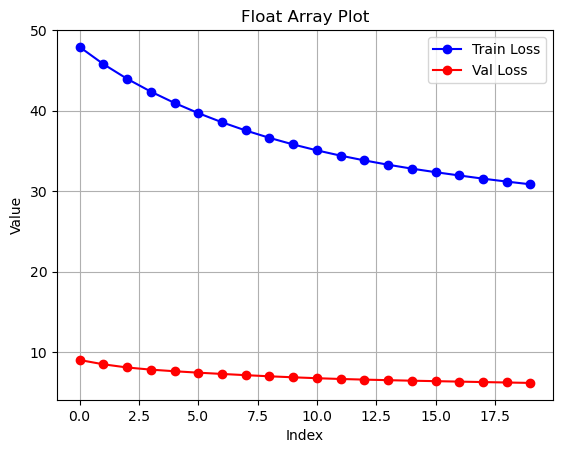

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
startPoint=20
# Example float array
val_array = valLosses[startPoint:]
train_array = trainLosses[startPoint:]

# Create an x-axis for the data points
x = np.arange(len(train_array))
y = np.arange(len(val_array))

# Plot the graph
plt.plot(x, train_array, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(y, val_array, marker='o', linestyle='-', color='r', label='Val Loss')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Float Array Plot')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [143]:
# Extract one batch of data for testing
model.to(device)
for sequences, targets in train_loader:
    testInput = sequences.to(device)  # Sequence data
    # testInput.to(device)
    print(f"Test Input Shape: {testInput.shape}")
    realOutput = targets   # Ground truth output
    break

# Ensure the model is in evaluation mode
model.eval()

# Predict using the model
with torch.no_grad():  # Disable gradient calculations for inference
    predicted = model(testInput).squeeze()  # Forward pass through the model

# Check shapes and results
print(f"Predicted Output Shape: {predicted.shape}")
print(f"First Prediction: {predicted[0].item()}")
print(f"Actual Output (First Target): {realOutput[0].item()}")

predicted
# testInput.shape

Test Input Shape: torch.Size([32, 7, 6])
Predicted Output Shape: torch.Size([32])
First Prediction: 0.045229971408843994
Actual Output (First Target): 0.04271427169442177


tensor([4.5230e-02, 1.6486e-02, 2.4266e-01, 1.6760e-02, 2.3425e-02, 2.1333e-02,
        5.7698e-03, 8.7743e-02, 3.0597e-02, 4.8004e-02, 7.9392e-02, 7.7771e-02,
        6.0423e-03, 1.8990e-02, 2.0806e-02, 1.0909e-01, 2.4974e-02, 1.5172e-01,
        3.9933e-01, 1.6192e-01, 1.7944e+01, 5.1782e-02, 2.0598e-01, 3.0508e+01,
        3.3764e-02, 1.7434e-02, 2.4963e-02, 1.2270e-01, 6.3469e-02, 2.8155e-02,
        1.8185e-01, 7.8433e-03], device='cuda:0')

In [144]:
realOutput

tensor([4.2714e-02, 1.3052e-02, 2.1574e-01, 8.8532e-03, 1.8071e-02, 1.8761e-02,
        1.2616e-03, 8.3142e-02, 2.3698e-02, 5.1450e-02, 7.6398e-02, 7.1266e-02,
        5.3477e-03, 1.1943e-02, 1.3763e-02, 1.0939e-01, 2.2065e-02, 1.4621e-01,
        3.7303e-01, 1.4807e-01, 1.7945e+01, 5.2223e-02, 2.0659e-01, 3.1335e+01,
        3.5885e-02, 9.4360e-03, 2.3699e-02, 1.1157e-01, 6.5198e-02, 2.4801e-02,
        1.8301e-01, 3.5260e-03])